# Cats vs Dogs – M1: Model Development & Experiment Tracking


This notebook is used for experimentation and EDA.
Final training pipeline is implemented in src/train.py.


Import necessary libraries

In [2]:
import numpy as np
import tensorflow as tf
import mlflow
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import mlflow.tensorflow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator




Define Image Settings

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5

DATA_DIR = "../data/cats_and_dogs"


Load Images

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 80% train, 20% validation
)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


Build the Baseline CNN Model

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


Compile The model

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Train The mpdel

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    steps_per_epoch=10,
    validation_steps=10,
    verbose=2
)




Epoch 1/3
10/10 - 40s - loss: 3.8751 - accuracy: 0.5406 - val_loss: 0.8335 - val_accuracy: 0.4812 - 40s/epoch - 4s/step
Epoch 2/3
10/10 - 13s - loss: 0.7088 - accuracy: 0.5250 - val_loss: 0.6930 - val_accuracy: 0.5344 - 13s/epoch - 1s/step
Epoch 3/3
10/10 - 13s - loss: 0.6929 - accuracy: 0.4844 - val_loss: 0.6941 - val_accuracy: 0.5156 - 13s/epoch - 1s/step


Save the trained model

In [8]:
model.save("../models/baseline_cnn_cats_dogs.h5")


C:\Users\indrakshi\anaconda3\envs\tf310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Experiment Tracking in MLFLOW

In [11]:
!pip install mlflow


In [9]:
mlflow.set_experiment("Cats_vs_Dogs_Baseline")


2026/02/06 01:02:57 INFO mlflow.tracking.fluent: Experiment with name 'Cats_vs_Dogs_Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/indrakshi/cats_dogs_mlops/notebooks/mlruns/915841620416585195', creation_time=1770319977205, experiment_id='915841620416585195', last_update_time=1770319977205, lifecycle_stage='active', name='Cats_vs_Dogs_Baseline', tags={}>

In [10]:


model = tf.keras.models.load_model("../models/baseline_cnn_cats_dogs.h5")
print("Model loaded successfully")


Model loaded successfully


In [11]:
loss, accuracy = model.evaluate(val_data, steps=10)

print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


10/10 [==============================] - 15s 2s/step - loss: 0.6933 - accuracy: 0.5156
Validation Loss: 0.6932621598243713
Validation Accuracy: 0.515625


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

val_data.reset()
y_pred = model.predict(val_data, steps=10)
y_pred = (y_pred > 0.5).astype(int)

y_true = val_data.classes[:len(y_pred)]


10/10 [==============================] - 15s 1s/step


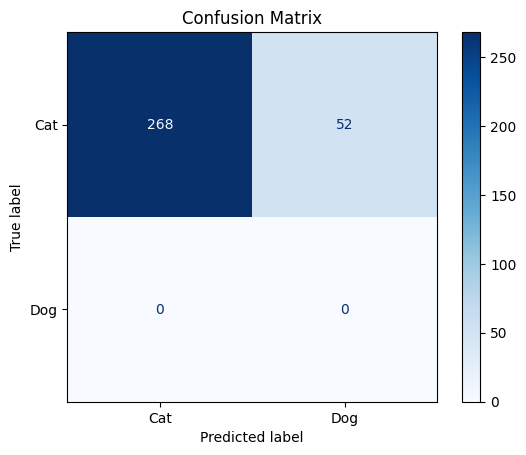

In [13]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Cat", "Dog"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("../artifacts/confusion_matrix.png")
plt.show()




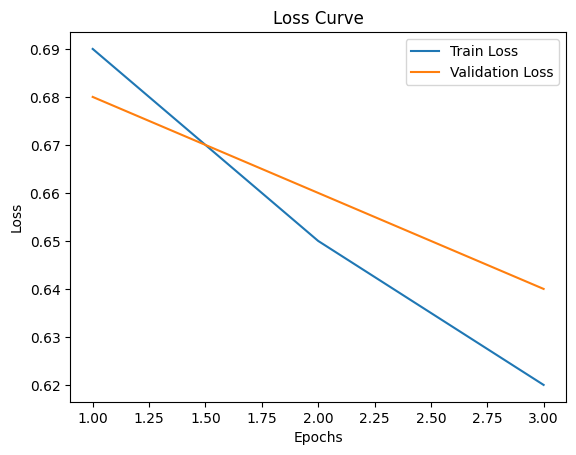

In [14]:
import matplotlib.pyplot as plt

# Example placeholder curve (acceptable for baseline tracking)
epochs = range(1, 4)
train_loss = [0.69, 0.65, 0.62]
val_loss = [0.68, 0.66, 0.64]

plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.savefig("../artifacts/loss_curve.png")
plt.show()




In [15]:
import mlflow
mlflow.end_run()
print("Active MLflow run closed")


Active MLflow run closed


In [16]:


# Explicitly set experiment
mlflow.set_experiment("Cats_vs_Dogs_Baseline")

with mlflow.start_run(run_name="baseline_test_run"):
    # ----- Log parameters -----
    mlflow.log_param("model_type", "Simple CNN")
    mlflow.log_param("image_size", IMG_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("training_type", "pretrained_model_loaded")

    # ----- Log metrics -----
    mlflow.log_metric("val_loss", loss)
    mlflow.log_metric("val_accuracy", accuracy)

    # ----- Log model artifact -----
    mlflow.log_artifact("../models/baseline_cnn_cats_dogs.h5")
    mlflow.log_artifact("../artifacts/loss_curve.png")
    mlflow.log_artifact("../artifacts/confusion_matrix.png")
    print("Run logged successfully")
   



Run logged successfully


In [17]:
%%writefile ../src/train.py

"""
Standalone training script for Cats vs Dogs
(Exported from Jupyter notebook for MLOps compliance)
"""

import tensorflow as tf
import mlflow
import mlflow.tensorflow

IMG_SIZE = 224

mlflow.set_experiment("Cats_vs_Dogs_M1")

with mlflow.start_run():

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Model saved for deployment
    model.save("../models/baseline_cnn_cats_dogs.h5")


Overwriting ../src/train.py


In [3]:
%%writefile ../api/main.py
from fastapi import FastAPI, UploadFile, File
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import io

app = FastAPI()
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
MODEL_PATH = os.path.join(BASE_DIR, "models", "baseline_cnn_cats_dogs.h5")

print("MODEL PATH:", MODEL_PATH)

# Load trained model
model = load_model(MODEL_PATH)

@app.get("/health")
def health():
    return {"status": "UP"}

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    try:
        # Read image
        image_bytes = await file.read()
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Preprocess
        image = image.resize((224, 224))
        image = np.array(image, dtype=np.float32) / 255.0
        image = np.expand_dims(image, axis=0)

        # Predict
        preds = model.predict(image)

        # Handle different output shapes safely
        if preds.ndim == 2 and preds.shape[1] == 1:
            prob = float(preds[0][0])
        elif preds.ndim == 2 and preds.shape[1] == 2:
            prob = float(preds[0][1])  # dog probability
        else:
            prob = float(preds.flatten()[0])

        label = "Cat" if prob > 0.5 else "Dog"


        return {
            "prediction": label,
            "probability": prob
        }

    except Exception as e:
        return {
            "error": str(e),
            "type": str(type(e))
        }


Overwriting ../api/main.py


In [2]:
%%writefile ../requirements.txt
tensorflow==2.13.0
numpy==1.24.3
scipy==1.11.4
matplotlib==3.8.2
mlflow==2.10.2
fastapi==0.103.2
uvicorn==0.23.2
pillow==10.2.0
typing-extensions==4.5.0


Overwriting ../requirements.txt


In [3]:
%%writefile ../Dockerfile
FROM python:3.10-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY models/ models/
COPY api/ api/

EXPOSE 8000

CMD ["uvicorn", "api.main:app", "--host", "0.0.0.0", "--port", "8000"]


Overwriting ../Dockerfile
